Load some libraries we will use:

In [1]:
#from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-whitegrid')
import seaborn as sns

C:\Users\Lindholm\AppData\Local\Temp\ipykernel_14212\1312662018.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<br>

# AS-AD model
(Exercise inspired by Jeppe Druedahl's exercises for https://numeconcopenhagen.netlify.app/)

Consider the following AS-AD model with a Taylor rule. The AD curve, obtained by combining the Taylor rule and goods market clearing, is given by  
$$
\pi_{t} = \pi^{*}-\frac{1}{\alpha}\left[y_{t}-\bar{y}-z_{t}\right]
$$
where $ \alpha = \frac{\alpha_2h}{1+\alpha_2b}$ and $z_t = \frac{v_t}{1+\alpha_2b}$. 

[Note compared to lecture we are implicitly setting $\hat{\rho}_t=g_t=\bar{g}=0$.]

The short-run supply curve (SRAS) is given by
$$
\pi_{t} = \pi_{t}^{e} + \gamma (y_{t}-\bar{y}) + s_{t}
$$
where $s_t$ is a supply shock. 

Inflation expectations are adaptive and given by
$$
\pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}
$$
Together, this implies that the SRAS-curve can also be written as
$$
\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}
$$

<br>

## 1. Define parameters (10%)
Assume we want to calibrate a quarterly model. Choose values for the parameters below and save them in a dictionary called par. Justify the value you set for each parameter.

In [2]:
par = {}

par['alpha2'] = 1 # Is the responsiveness/slope of the real interest rate gap in the IS-curve: alpha_2(r - r_trend).
par['h'] = 1/2 # Chosen by the CB. 1 - h > 0. Range is (1/4, 1/2) in the book. 
par['b'] = 1/2 # Chosen by the CB.
par['phi'] = 1/2 # Is the weight given to the previous period's expected and actual inflation. Low phi -> quicker adjustment based on pi_t-1. 
par['gamma'] = 0.5 # Is the responsivness of current inflation to the output gap. No effect in steady state when y_bar = 0. 
par['pistar'] = 0 # zero inflation in steady state
par['ybar'] = 0 # zero output gap in steady state

<br>

## 2. Solve for the equilibrium

Next, we use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$ given the parameters ($\alpha_2$, $h$, $b$, $\phi$, $\gamma$) and initial values $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$. The equilibrium is defined by the point where AD = SRAS. 

We will do this together since the rest of the assignment relies on these functions. First we construct the AD curve (Step 1), then the AS curve (Step 2), and finally we compute the equilibrium functions (Step 3).

``SymPy`` should automatically render these as typeset "pretty" equations.

<br>

### 2.1 Construct the AD curve: 
We construct the AD curve, $\pi_{t} = \pi^{*}-\frac{1}{\alpha}\left[y_{t}-\bar{y}-z_{t}\right]
$, where $ \alpha = \frac{\alpha_2h}{1+\alpha_2b}$ and $z_t = \frac{v_t}{1+\alpha_2b}$.

In [3]:
y = sm.symbols('y_t')
ybar = sm.symbols('\\bar{y}')
v = sm.symbols('v_t')
alpha2 = sm.symbols('alpha_2')
pistar = sm.symbols('\pi^{*}')
h = sm.symbols('h')
b = sm.symbols('b')
alpha = sm.symbols('alpha')
z = sm.symbols('z_t')

z = v/(1+alpha2*b)
alpha = alpha2*h/(1+alpha2*b)
AD = pistar-1/alpha * (y-ybar-z)
AD

\pi^{*} - (alpha_2*b + 1)*(-\bar{y} - v_t/(alpha_2*b + 1) + y_t)/(alpha_2*h)

<br>

### 2.2 Construct the AS curve: 
Similarly for the SRAS curve, $\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}$

In [4]:
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')
pilag = sm.symbols('\pi_{t-1}')
ylag = sm.symbols('y_{t-1}')
s = sm.symbols('s_t')
slag = sm.symbols('s_{t-1}')

SRAS = pilag + gamma*y- phi*gamma*ylag + s - phi*slag
SRAS

\pi_{t-1} - gamma*phi*y_{t-1} + gamma*y_t - phi*s_{t-1} + s_t

<br>

### 2.3 Find the solution: 
Next we find the solution for output by equating AS and AD using ``sympy``'s ``solve`` and ``Eq`` methods. 

To find the solution for inflation, evaluate either the AD or AS curve at the equilibrium output value we just found using the ``subs`` method.

In [5]:
y_eq = sm.solve(sm.Eq(AD,SRAS),y)
y_eq[0]

(\bar{y}*alpha_2*b + \bar{y} + \pi^{*}*alpha_2*h - \pi_{t-1}*alpha_2*h + alpha_2*gamma*h*phi*y_{t-1} + alpha_2*h*phi*s_{t-1} - alpha_2*h*s_t + v_t)/(alpha_2*b + alpha_2*gamma*h + 1)

In [6]:
pi_eq = AD.subs(y,y_eq[0])
pi_eq

\pi^{*} - (alpha_2*b + 1)*(-\bar{y} - v_t/(alpha_2*b + 1) + (\bar{y}*alpha_2*b + \bar{y} + \pi^{*}*alpha_2*h - \pi_{t-1}*alpha_2*h + alpha_2*gamma*h*phi*y_{t-1} + alpha_2*h*phi*s_{t-1} - alpha_2*h*s_t + v_t)/(alpha_2*b + alpha_2*gamma*h + 1))/(alpha_2*h)

<br>

## 3. Illustrate the equilibrium (20%)
The code below finds and illustrates (= plots in $(y,\pi)$-space) the equilibrium without shocks, that is, when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. 

After going through the code, you are asked to find and illustrate the equilibrium with $v_t = 0.1$.

Convert the ``SymPy`` functions to ``NumPy`` functions that can be evaluated quickly numerically using lambdify:

In [7]:
AD_func = sm.lambdify((y,v,alpha2,h,b,pistar,ybar),AD)
SRAS_func = sm.lambdify((y,s,ylag,pilag,slag,phi,gamma),SRAS)
y_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha2,h,b,pistar,ybar,phi,gamma),y_eq[0])
pi_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha2,h,b,pistar,ybar,phi,gamma),pi_eq)

Construct grids to draw the curves

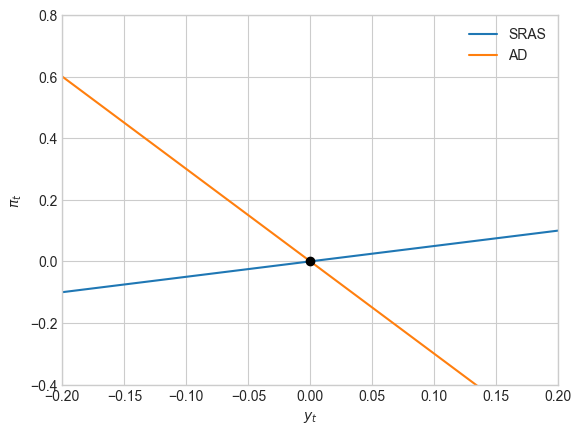

In [8]:
# a. lagged values and shocks 
y0_lag = 0.0
pi0_lag = 0.0
s0 = 0.0
s0_lag = 0.0

# b. current output
y_vec = np.linspace(-0.2,0.2,100)

# c. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# SRAS
pi_SRAS = SRAS_func(y_vec,s0,y0_lag,pi0_lag,s0_lag,par['phi'],par['gamma'])
ax.plot(y_vec,pi_SRAS,label='SRAS')

# AD
v0 = 0
pi_AD = AD_func(y_vec,v0,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'])
ax.plot(y_vec,pi_AD,label='AD')

# equilibrium
eq_y = y_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
eq_pi =pi_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
ax.scatter(eq_y,eq_pi,color='black',zorder=3)

# Set axes limits for easier comparison.
ax.set_xlim(-0.20, 0.20)
ax.set_ylim(-0.4, 0.8)

ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.legend();

<br>

### Your job: 
Find and add to the plot the AD and AS curves, along with the equilibrium points, when $v_t = 0.1$. Explain in economic terms what changes and why when $v_t = 0$ versus when $v_t = 0.1$.

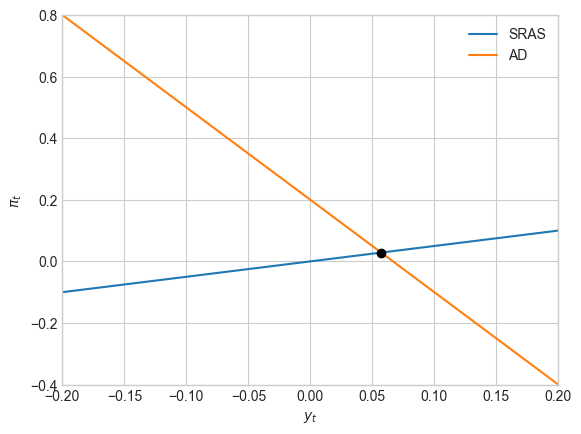

In [9]:
# a. lagged values and shocks 
y0_lag = 0.0
pi0_lag = 0.0
s0 = 0.0
s0_lag = 0.0

# b. current output
y_vec = np.linspace(-0.2,0.2,100)

# c. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# SRAS
pi_SRAS = SRAS_func(y_vec,s0,y0_lag,pi0_lag,s0_lag,par['phi'],par['gamma'])
ax.plot(y_vec,pi_SRAS,label='SRAS')

# AD
v0 = 0.1 # Add a confidence shock to demand in present periods. 
pi_AD = AD_func(y_vec,v0,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'])
ax.plot(y_vec,pi_AD,label='AD')

# equilibrium
eq_y = y_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
eq_pi =pi_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
ax.scatter(eq_y,eq_pi,color='black',zorder=3)

# Set axes limits for easier comparison.
ax.set_xlim(-0.20, 0.20)
ax.set_ylim(-0.4, 0.8)

ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.legend();

<br>

### Explanation

- $v_t=0.1$ adds a confidence shock to demand in the current period. 
- The shock shifts the AD-curve up but does not affect the SRAS curve.
- In the new equilibrium, both output $y_t$ and inflation $\pi_t$ has increased.
- Compared to the equilibrium $(\pi =\pi^*, $y_t=\bar{y})$ where there is 0 output gap, demand has now created greater output potential than in the steady state.
- A positive demand shock is a temporary increase in consumption and investment which causes output $y_t$ to grow. By definition of the IS-curve used to derive the AD-curve, it increases the output gap:

$y_t - \bar{y} = \alpha_1(g_t-\bar{g}) - \alpha_2(r_t - \bar{r}) - \alpha_3(\tau_t - \bar{\tau}) + v_t$

- The SRAS-curve has an upward slope through the term $\gamma y_t$ because $\gamma > 0$. This corresponds to a higher equilibrium inflation when the AD curve is moved up.
- Greater demand puts an upward pressure on prices and wages which causes higher inflation.

<br>

## 4. Impulse responses (30%)
Now we will assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
v_{t} &= \delta v_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a demand shock, and $c_t$ is a supply shock 

The autoregressive parameters are given by

In [10]:
par['delta'] = 0.80
par['omega'] = 0.15

Assume that $x_t$ and $c_t$ are  normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

with standard deviations

In [11]:
par['sigma_x'] = 1.0
par['sigma_c'] = 0.2

<br>

We will now construct impulse responses to answer the following question: *Starting from the long-run equilibrium, how does the economy evolve in response to a one-time, one standard-deviation demand shock?* 

The starting point of the economy is $y_{-1} = \pi_{-1} = s_{-1} = 0$. 
The shock sequence we are considering is: $x_0 = \sigma_x$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$.

*Step 1*
Define two functions that we will reuse later:
1. allocate memories and draw random shocks given parameters and the number of time periods we want to simulate
2. simulate the economy given the shock sequences from 1. 

*Step 2*
Run the simulations.

*Step 3*
Illustrate the results in two ways: 
1. in $(y,\pi)$-space, and 
2. plotting $y$ and $\pi$ as a function of periods since the shock. 

<br>

**Step 1**:
Define function prep_sim to **allocate memory and draw random shocks**

In [12]:
seed = 1986

In [13]:
def prep_sim(par,T,seed=seed):
    """ prepare simulation
    
    Args:
    
        par (dict): model parameters
        T (int): number of periods to simulate
        seed (int,optional): seed for random numbers
        
    Returns:
    
        sim (dict): container for simulation results
        
    """
    
    # a. Set seed.
    if seed is not None:
        np.random.seed(seed)
    
    # b. Allocate memory.
    sim = {}
    sim['y'] = np.zeros(T)
    sim['pi'] = np.zeros(T)
    sim['v'] = np.zeros(T)
    sim['s'] = np.zeros(T)
    
    # c. Draw random shocks.
    sim['x_raw'] = np.random.normal(loc=0,scale=1,size=T)
    sim['c_raw'] = np.random.normal(loc=0,scale=1,size=T) 

    # d. Allocate room for nominal and real interest rates.
    sim["i"] = np.zeros(T)
    sim["r"] = np.zeros(T)
    
    return sim

**Step 1 (continued)**:
Define function **simulate** to run the simulations

In [14]:
def simulate(par, sim, T):
    """ Run simulation.
    
    Args:
        par (dict): model parameters
        sim (dict): container for simulation results
        T (int): number of periods to simulate
                
    """
    
    for t in range(1,T):
        
        # a. Shocks.
        sim['v'][t] = par['delta']*sim['v'][t-1] + par['sigma_x']*sim['x_raw'][t]
        sim['s'][t] = par['omega']*sim['s'][t-1] + par['sigma_c']*sim['c_raw'][t]
        
        # b. Output.
        sim['y'][t] = y_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        
        # c. Inflation.
        sim['pi'][t] = pi_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                  par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        

<br>

**Step 2:** Run the simulations

In [ ]:
# a. Settings: number of periods to simulate.
T = 100

# b. Prepare simulation.
sim = prep_sim(par,T)

# c. Define (overwrite) shock sequences. We want a one time, one standard deviation increase in x_t in period 1 only.
# => No shocks in any period except the first.
sim['x_raw'][:] = 0
sim['c_raw'][:] = 0
sim['x_raw'][1] = 1 # 1 is used to multiply with sigma_x. The rest of the shocks are multiplied with 0.

# d. Run simulation
simulate(par,sim,T)

<br>

**Step 3:** Plot the simulated time series in a **$(y_t,\pi_t)$-diagram**.

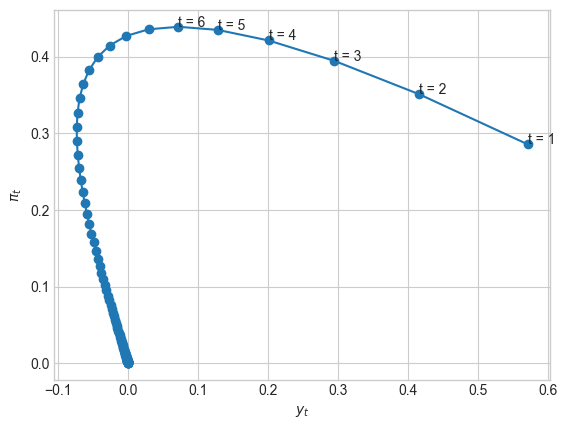

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:], sim['pi'][1:], ls='-', marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

**Step 3 (continued):** Plot the simulated series for output and inflation **over time**.

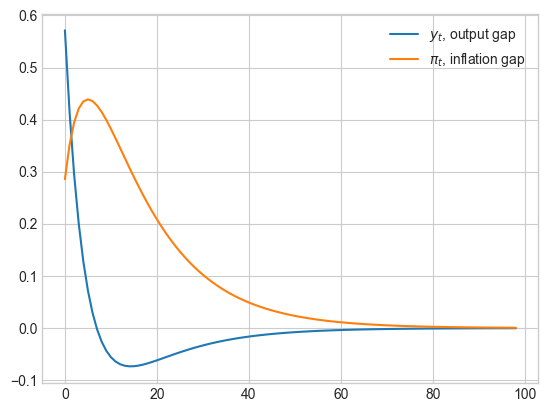

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['y'][1:],label='$y_t$, output gap')
ax.plot(np.arange(0,T-1),sim['pi'][1:],label='$\pi_t$, inflation gap')
ax.legend();

<br>

### Your job: 
1. Add code to also simulate the nominal and real interest rates and add a figure that plot the simulated time series over time. Assume the central bank follows a Taylor rule of the form $i_t =\pi_t +h(\pi_t-\pi^*)+b(y_t-\bar{y})$.

2. Explain the response of the economy to the demand shock in economic terms.

3. Add code below to simulate the economy's response to a one time, one standard deviation *supply* shock, that is $c_0 = \sigma_c$, $c_t = 0, \forall t > 0$ and $x_t = 0, \forall t \geq 0$.

4. Produce 3 figures: Plot the simulated data for output gap and inflation in $(y,\pi)$-space and over time, and plot the response of the nominal and real interest rates over time. 

5. Explain the response of the economy to the supply shock in economic terms.

In [18]:
def simulate_rates(par, sim, T):
    """ Simulate nominal and real interest rates, i and r.
    
    """

    for t in range(1, T):
        # Central Bank sets i according to the Taylor rule.
        sim["i"][t] = sim["pi"][t] + par["h"]*(sim["pi"][t] - par["pistar"]) + par["b"]*(sim["y"][t] - par["ybar"])

        # Real interest r according to the Fisher equation.
        sim["r"][t] = sim["i"][t] - (par["phi"]*sim["pi"][t-1] + (1-par["phi"])*sim["pi"][t-1])


In [19]:
simulate_rates(par, sim, T)

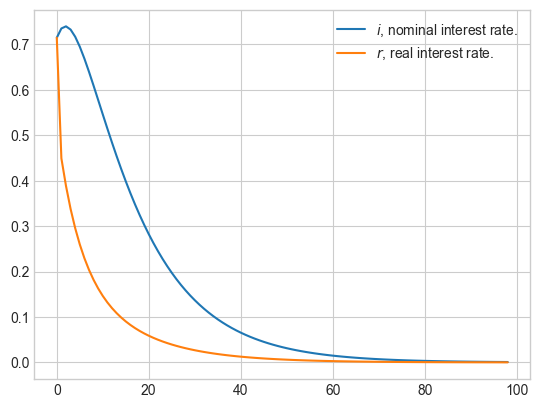

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = np.arange(0, T-1)
ax.plot(x, sim["i"][1:], label="$i$, nominal interest rate.")
ax.plot(x, sim["r"][1:], label="$r$, real interest rate.")
ax.legend();

<br>

### Explanation
The CB sets the nominal interest rate $i$ at a high value in the beginning because of the demand shocks. Demand shocks widen both the output and the inflation gaps which the nominal interest rate depends on in the Taylor rule equation:

$i_t =\pi_t +h(\pi_t-\pi^*)+b(y_t-\bar{y})$

The real interest rate $r_t = i_t - \pi_{t+1}^e$ approaches 0 when the nominal rate and expected inflation have values close to each other. 

The expected inflation is determined by expected and actual inflation in the previous period: 

$\pi_{t+1}^e = \phi \pi_{t}^e + (1-\phi)\pi_{t}$

The stabilization parameter $\phi$ reflects how much weight the CB puts on actual and expected inflation in the current period.

The graph shows how the CB initially chooses a high nominal rate to dampen inflation. The real interest falls as the difference between the nominal rate and expected inflation is reduced. As the higher rates dampen inflation, the difference between the two rates begins to disappear. The two rates converge toward 0 as inflation and output gaps become small. 

### One time supply shock

In [21]:
sim = prep_sim(par, T, seed)

# No demand shocks.
sim["x_raw"][:] = 0 
# Start with no supply shocks.
sim["c_raw"][:] = 0  
# Add a one time supply shock.
sim["c_raw"][1] = 1 

simulate(par, sim, T)

#### Plot: output gap and inflation in $(y,\pi)$-space.

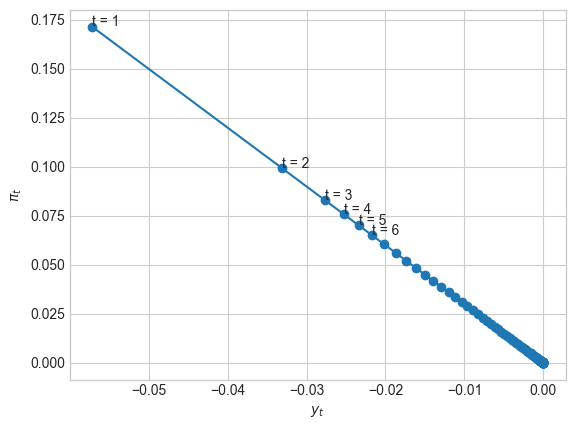

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:], sim['pi'][1:], ls='-', marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

In [23]:
sim.keys()

dict_keys(['y', 'pi', 'v', 's', 'x_raw', 'c_raw', 'i', 'r'])

#### Plot: Output gap and inflation over time.

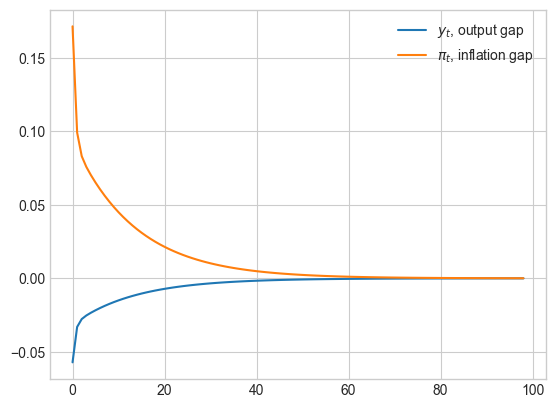

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, sim['y'][1:],label='$y_t$, output gap')
ax.plot(x, sim['pi'][1:],label='$\pi_t$, inflation gap')
ax.legend();

In [27]:
simulate_rates(par, sim, T)

#### Plot: Nominal and interest rates over time.

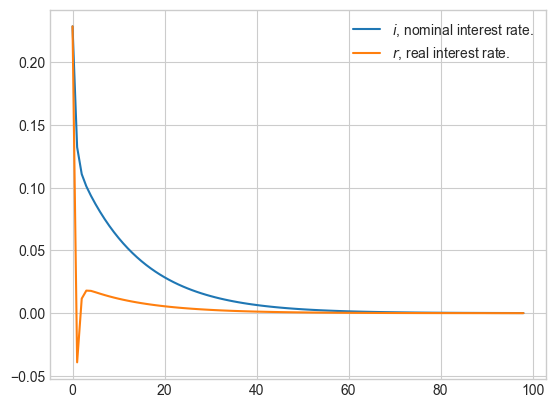

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = np.arange(0, T-1)
ax.plot(x, sim["i"][1:], label="$i$, nominal interest rate.")
ax.plot(x, sim["r"][1:], label="$r$, real interest rate.")
ax.legend();

## 5. Simulating the model and calculating business cycle statistics (20%)

Continue to make the same assumptions about the shock processes as in the last question. Now instead of computing impulse responses (a one-time shock) simulate the AS-AD model for 100 periods (drawing a realization of $x_t$ and $c_t$ each of these periods). Plot the resulting time series and calculate the following five statistics using ``std`` and ``corrcoef`` from ``numpy``:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$ 
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

Are output and inflation positively or negatively related? Why? What might change the sign and magnitude of the correlation?

In [29]:
# your code here        

<br>

## 6. Calibration (20%)

Now based on simulations of T=100 periods each, plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Explain. What value of $\phi$ brings the correlation between inflation and output close to its empirical counterpart of 0.31? 

How large does $T$ need to be for this value to not change very much with each simulation?

If you would like to, you can use a numerical optimizer or root finder to choose $\phi\in(0,1]$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

In [30]:
# your code here